## MY CNN model

Test CNN model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (500,500)
IMG_W = 500
IMG_H = 500
# IMG_SIZE = (300,300)
# IMG_W = 300
# IMG_H = 300
# IMG_SIZE = (400,518)
# IMG_W = 400
# IMG_H = 518

In [4]:
train_dataset = image_dataset_from_directory("../../data_expanding/train/",
#                                             "../../data_grayscale_split/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 1369 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory("../../data_expanding/val/",
#                                                   "../../data_grayscale_split/val/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 299 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

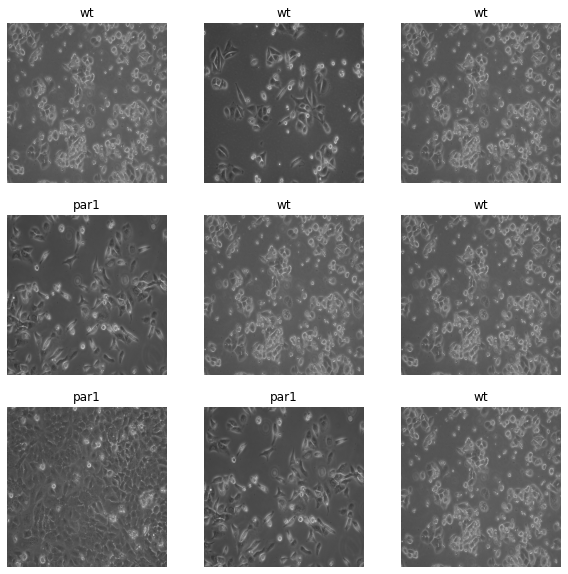

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print("Number of validation batches : %d" %tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches : %d" %tf.data.experimental.cardinality(test_dataset))

Number of validation batches : 8
Number of test batches : 2


In [10]:
AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomCrop(round(IMG_W/2), round(IMG_H/2)),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5)) #newly added
])

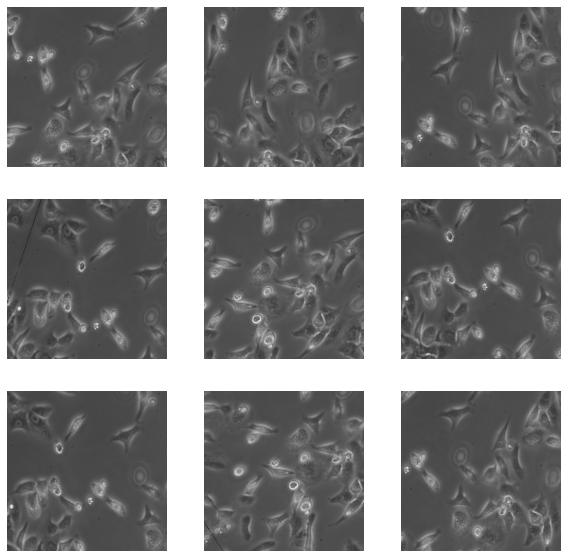

In [15]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [17]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [27]:
drop_rate = 0.4 #looks it works better than 0.5

model = Sequential([
        data_augmentation,
        rescale,
        Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(drop_rate),
        Flatten(),
        Dropout(drop_rate),
        Dense(units=128, activation='relu'),
        Dropout(drop_rate),
        Dense(units=128, activation='relu'),
#         Dense(units=1, activation='softmax')
        Dense(units=1, activation='relu')
    ])

In [29]:
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [31]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training ...")
    def on_train_end(self, logs=None):
        print("Finished training!")

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [33]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 3s 367ms/step - loss: 0.6931 - accuracy: 0.4255


In [34]:
print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

initial loss : 0.69
initial accuracy : 0.43


In [35]:
history = model.fit(train_dataset,
                   epochs=initial_epochs,
                   validation_data=validation_dataset,
                   callbacks=[TrainingCallback(), early_stopping])

Starting training ...
Epoch 1/20
43/43 [==============================] - 29s 669ms/step - loss: 0.5846 - accuracy: 0.6742 - val_loss: 0.6668 - val_accuracy: 0.5617
Epoch 2/20
43/43 [==============================] - 19s 441ms/step - loss: 0.5262 - accuracy: 0.7239 - val_loss: 0.8348 - val_accuracy: 0.5489
Epoch 3/20
43/43 [==============================] - 19s 445ms/step - loss: 0.5079 - accuracy: 0.7334 - val_loss: 0.8881 - val_accuracy: 0.5830
Epoch 4/20
43/43 [==============================] - 19s 444ms/step - loss: 0.4967 - accuracy: 0.7429 - val_loss: 0.9609 - val_accuracy: 0.6000
Epoch 5/20
43/43 [==============================] - 20s 456ms/step - loss: 0.5143 - accuracy: 0.7290 - val_loss: 0.7032 - val_accuracy: 0.5447
Epoch 6/20
43/43 [==============================] - 19s 447ms/step - loss: 0.4951 - accuracy: 0.7443 - val_loss: 0.8621 - val_accuracy: 0.5447
Epoch 7/20
43/43 [==============================] - 19s 445ms/step - loss: 0.4899 - accuracy: 0.7531 - val_loss: 0.9802 

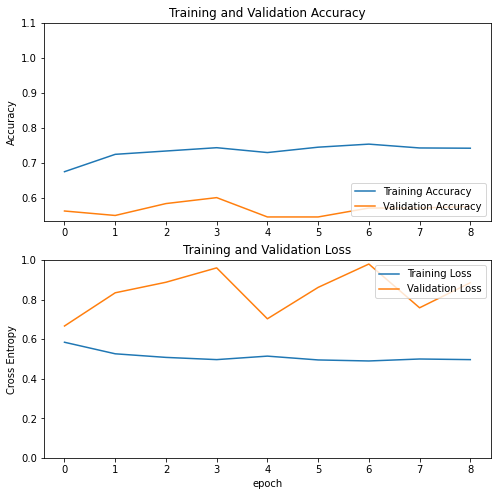

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']